In [1]:
!pip install --upgrade --force-reinstall numpy pandas catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 914.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 83.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.9/229.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 347.8/347.8 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [11]:
!pip install optuna

  Using cached optuna-4.2.1-py3-none-any.whl.metadata (17 kB)
  Using cached alembic-1.15.2-py3-none-any.whl.metadata (7.3 kB)
  Using cached colorlog-6.9.0-py3-none-any.whl.metadata (10 kB)
Using cached optuna-4.2.1-py3-none-any.whl (383 kB)
Using cached alembic-1.15.2-py3-none-any.whl (231 kB)
Using cached colorlog-6.9.0-py3-none-any.whl (11 kB)


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from catboost import CatBoostRegressor, Pool
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel("/content/drive/MyDrive/Internships/Prasunet Foundation-Data Science/dataset/cleaned_car_data.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   name_model                  781 non-null    object        
 1   make_year                   781 non-null    int64         
 2   registration_year           781 non-null    int64         
 3   fuel_type                   781 non-null    object        
 4   km_driven                   781 non-null    int64         
 5   transmission                781 non-null    object        
 6   no_of_owner                 781 non-null    int64         
 7   insurance_validity          781 non-null    datetime64[ns]
 8   insurance_type              781 non-null    object        
 9   car_location                781 non-null    object        
 10  avg_tyre_life%              781 non-null    int64         
 11  mileage_kmpl                781 non-null    float64       

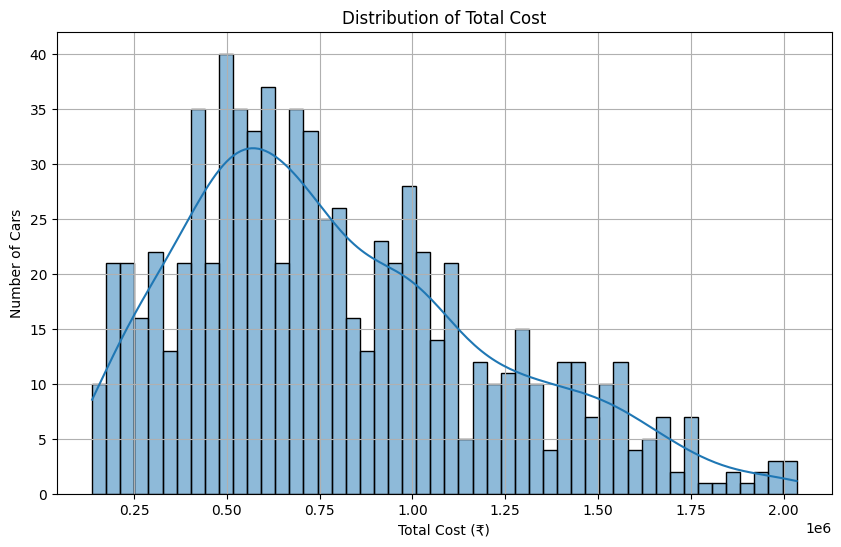

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(df['total_cost'], bins=50, kde=True)
plt.title("Distribution of Total Cost")
plt.xlabel("Total Cost (₹)")
plt.ylabel("Number of Cars")
plt.grid(True)
plt.show()

In [5]:
print(df['total_cost'])

0      362400
1      768768
2      493620
3      738408
4      375984
        ...  
776    429858
777    329802
778    455136
779    302100
780    598092
Name: total_cost, Length: 781, dtype: int64


In [6]:
df['total_cost'].describe()

,total_cost
count,7.810000e+02
mean,7.992515e+05
std,4.136016e+05
min,1.371840e+05
25%,4.867500e+05
50%,7.125360e+05
75%,1.044120e+06
max,2.034780e+06


In [7]:
quantiles = df['total_cost'].quantile([0.33, 0.66])

def price_segment(cost):
    if cost <= quantiles[0.33]:
        return 'Budget'
    elif cost <= quantiles[0.66]:
        return 'Mid-Range'
    else:
        return 'Premium'

df['price_segment'] = df['total_cost'].apply(price_segment)

print(df['price_segment'].value_counts())

price_segment
Premium      265
Budget       258
Mid-Range    258
Name: count, dtype: int64


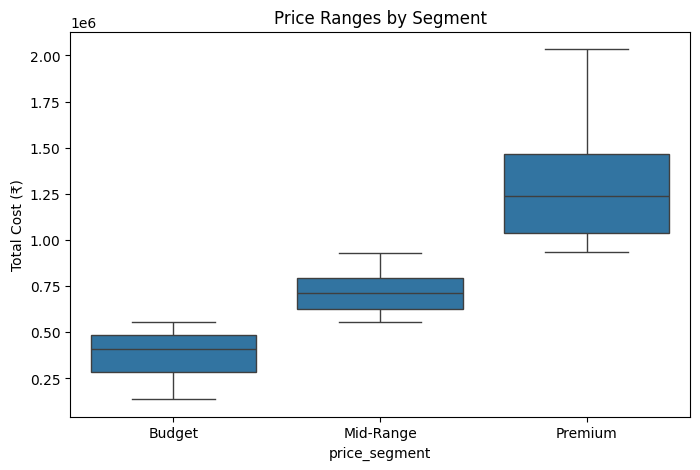

In [8]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='price_segment', y='total_cost')
plt.title("Price Ranges by Segment")
plt.ylabel("Total Cost (₹)")
plt.show()

In [9]:
# Define your features
categorical_features = ['brand', 'transmission', 'car_location','price_segment']

numerical_features = [
    'km_driven', 'avg_tyre_life%',
    'fuel_tank_capacity', 'displacement',
    'car_age','no_of_owner',
    'mileage_per_cc', 'bootspace_per_seat'
]

features_to_use = categorical_features + numerical_features
df['total_cost_log'] = np.log1p(df['total_cost'])

# Sample weights (more penalty for cheaper cars)
df['sample_weight'] = 1 / (df['total_cost'] + 1e-5)
df['sample_weight'] /= df['sample_weight'].mean()

X = df[features_to_use]
y = df['total_cost_log']

weights = df['sample_weight']
X_train, X_valid, y_train, y_valid, w_train, w_valid = train_test_split(
    X, y, weights, test_size=0.2, random_state=42)

train_pool = Pool(X_train, y_train, cat_features=categorical_features, weight=w_train)
valid_pool = Pool(X_valid, y_valid, cat_features=categorical_features, weight=w_valid)

In [12]:
import optuna

def objective(trial):
    params = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 4, 10),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
        "bootstrap_type": "Bayesian",
        "eval_metric": "RMSE",
        "loss_function": "RMSE",
        "random_seed": 42,
        "early_stopping_rounds": 50,
        "verbose": False
    }
    model = CatBoostRegressor(**params)
    model.fit(train_pool, eval_set=valid_pool, use_best_model=True)
    preds = model.predict(valid_pool)
    rmse = np.sqrt(mean_squared_error(np.expm1(y_valid), np.expm1(preds)))
    return rmse

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)
best_params = study.best_params
print("Best Parameters:", best_params)

[I 2025-04-12 06:02:33,786] A new study created in memory with name: no-name-355cc586-d43d-4afc-a13d-d9ee749e4a00
[I 2025-04-12 06:02:39,918] Trial 0 finished with value: 139910.3981644624 and parameters: {'learning_rate': 0.03108572991228662, 'depth': 8, 'l2_leaf_reg': 0.9748680494288631}. Best is trial 0 with value: 139910.3981644624.
[I 2025-04-12 06:02:42,412] Trial 1 finished with value: 144998.8198785722 and parameters: {'learning_rate': 0.05165468159570417, 'depth': 4, 'l2_leaf_reg': 1.0789923002935393}. Best is trial 0 with value: 139910.3981644624.
[I 2025-04-12 06:02:46,489] Trial 2 finished with value: 146129.65845642326 and parameters: {'learning_rate': 0.09155785160839036, 'depth': 9, 'l2_leaf_reg': 0.058057978394983945}. Best is trial 0 with value: 139910.3981644624.
[I 2025-04-12 06:02:46,745] Trial 3 finished with value: 143407.83423573073 and parameters: {'learning_rate': 0.22734183041086858, 'depth': 6, 'l2_leaf_reg': 0.0021677236798345084}. Best is trial 0 with value

Best Parameters: {'learning_rate': 0.04271616750473267, 'depth': 6, 'l2_leaf_reg': 0.5791053928965454}


In [13]:
final_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=best_params["learning_rate"],
    depth=best_params["depth"],
    l2_leaf_reg=best_params["l2_leaf_reg"],
    bootstrap_type="Bayesian",
    eval_metric="RMSE",
    loss_function="RMSE",
    random_seed=42,
    early_stopping_rounds=50,
    verbose=100
)

# Fit the final model
final_model.fit(train_pool, eval_set=valid_pool, use_best_model=True)

# Predict and evaluate
y_pred_log = final_model.predict(valid_pool)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)

r2 = r2_score(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

print("\n📊 Final Optuna-Tuned CatBoost Performance")
print(f"R² Score:     {r2:.4f}")
print(f"RMSE:         ₹{rmse:,.2f}")
print(f"MAE:          ₹{mae:,.2f}")
print(f"MAPE:         {mape:.2f}%")

0:	learn: 0.5766581	test: 0.6550971	best: 0.6550971 (0)	total: 2.9ms	remaining: 2.89s
100:	learn: 0.1229815	test: 0.2074089	best: 0.2074089 (100)	total: 219ms	remaining: 1.95s
200:	learn: 0.0851391	test: 0.1933098	best: 0.1928033 (189)	total: 467ms	remaining: 1.85s
300:	learn: 0.0644188	test: 0.1904076	best: 0.1898723 (288)	total: 690ms	remaining: 1.6s
400:	learn: 0.0521323	test: 0.1877736	best: 0.1877736 (400)	total: 921ms	remaining: 1.38s
500:	learn: 0.0428994	test: 0.1873587	best: 0.1872950 (470)	total: 1.15s	remaining: 1.15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.1868802308
bestIteration = 541

Shrink model to first 542 iterations.

📊 Final Optuna-Tuned CatBoost Performance
R² Score:     0.9180
RMSE:         ₹130,455.80
MAE:          ₹88,343.63
MAPE:         11.87%


In [14]:
def display_predictions_table(model, X_test, y_test, top_n=20):
    y_pred_log = model.predict(X_test)
    y_test_actual = np.expm1(y_test)
    y_pred_actual = np.expm1(y_pred_log)
    differences = np.abs(y_test_actual - y_pred_actual)

    df_results = pd.DataFrame({
        'Actual Cost (₹)': y_test_actual,
        'Predicted Cost (₹)': y_pred_actual,
        'Difference (₹)': differences
    }).round(2)

    print("\n📊 Sample Predictions – Optuna-Tuned CatBoost\n")
    print(df_results.head(top_n).to_string(index=True))
    return df_results

# Run it
display_predictions_table(final_model, valid_pool, y_valid)



📊 Sample Predictions – Optuna-Tuned CatBoost

     Actual Cost (₹)  Predicted Cost (₹)  Difference (₹)
595         425964.0           446543.06        20579.06
587         333762.0           377109.96        43347.96
543         298386.0           317815.26        19429.26
645        1721874.0          1620014.10       101859.90
487         598488.0           654677.98        56189.98
211         234072.0           267181.15        33109.15
388         224424.0           254065.08        29641.08
527         311088.0           249368.05        61719.95
244         596772.0           679492.10        82720.10
582         773256.0           720022.34        53233.66
368         921624.0           885155.72        36468.28
634         637230.0           747726.70       110496.70
749        1219416.0          1168908.81        50507.19
615         975546.0          1024783.68        49237.68
767         183648.0           183732.33           84.33
155         678810.0           711028.50 

,Actual Cost (₹),Predicted Cost (₹),Difference (₹)
595,425964.0,446543.06,20579.06
587,333762.0,377109.96,43347.96
543,298386.0,317815.26,19429.26
645,1721874.0,1620014.10,101859.90
487,598488.0,654677.98,56189.98
...,...,...,...
79,1045242.0,1160098.55,114856.55
148,1099164.0,1110161.36,10997.36
333,538428.0,487537.50,50890.50
168,166392.0,226888.54,60496.54


<ipython-input-15-005673def2cd>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance (%)', y='Feature', data=feature_imp_df, palette='viridis')


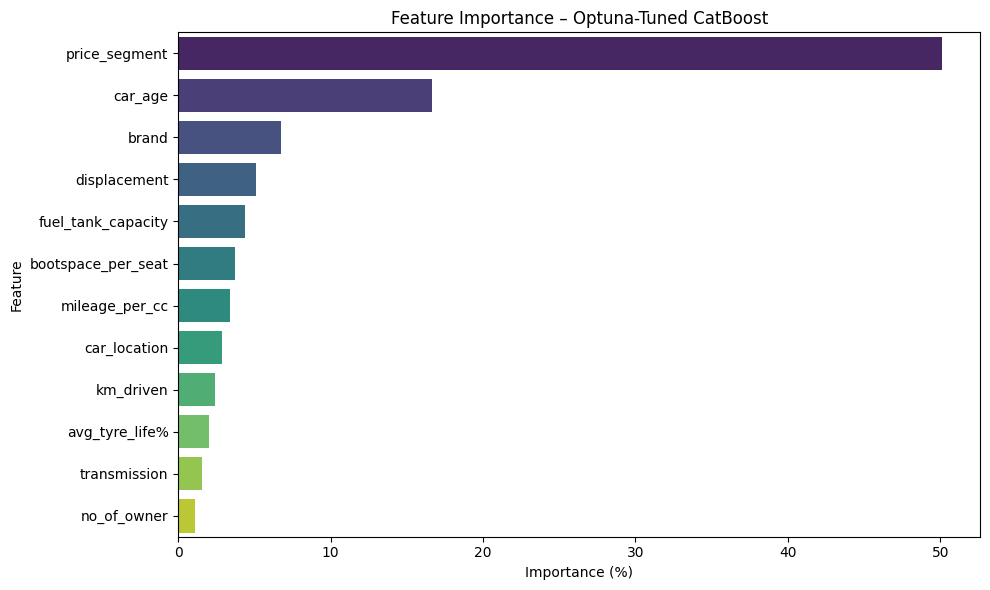

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns

# Combine into a DataFrame
feature_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Normalize to percentage (optional)
feature_imp_df['Importance (%)'] = (feature_imp_df['Importance'] / feature_imp_df['Importance'].sum()) * 100

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance (%)', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Feature Importance – Optuna-Tuned CatBoost')
plt.xlabel('Importance (%)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [18]:
# Save the model
final_model.save_model("/content/drive/MyDrive/Internships/Prasunet Foundation-Data Science/code/catboost_final_model.cbm")